In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def sinkhorn_with_polarization(C, a, b, P, P_max, epsilon, dual_lr=0.1, precision=1e-6, max_iter=10000):
    n, m = C.shape
    kappa = 0.0
    u = np.ones((n, 1))
    v = np.ones((m, 1))
    convergence = False

    # Histories for plotting
    polarization_history = []
    engagement_history = []
    objective_history = []
    kappa_history = []
    iteration_history = []

    # Initial adjusted cost matrix and kernel
    per_user_polarization = np.zeros(n)  # Initialize per-user polarization
    sign_per_user_polarization = np.zeros((n, 1))
    C_adjusted = C + kappa * sign_per_user_polarization * P[np.newaxis, :]
    max_exponent = 700
    exponent = -C_adjusted / epsilon
    exponent = np.clip(exponent, -max_exponent, max_exponent)
    K = np.exp(exponent)

    for iteration in range(max_iter):
        # Update scaling factors
        for _ in range(50):
            u_prev = u.copy()
            v_prev = v.copy()
            u = a / np.maximum(K @ v, 1e-100)
            v = b / np.maximum(K.T @ u, 1e-100)
            err_u = np.linalg.norm(u - u_prev)
            err_v = np.linalg.norm(v - v_prev)
            if err_u < precision and err_v < precision:
                break

        # Compute transport plan
        Pi = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())

        # Compute per-user polarization
        per_user_polarization = (Pi @ P) / a.flatten()
        average_abs_polarization = np.mean(np.abs(per_user_polarization))
        polarization_history.append(average_abs_polarization)

        # Compute engagement score (-<Pi, C>)
        engagement_score = -np.sum(Pi * C)
        engagement_history.append(engagement_score)

        # Compute objective function value
        entropy_term = -epsilon * np.sum(Pi * (np.log(Pi + 1e-100) - 1))
        objective = engagement_score + entropy_term
        objective_history.append(objective)

        # Store dual variable history
        kappa_history.append(kappa)
        iteration_history.append(iteration)

        # Check polarization constraint
        if average_abs_polarization > P_max + precision:
            # Update dual variable for polarization constraint
            polarization_violation = average_abs_polarization - P_max
            kappa += dual_lr * polarization_violation
            kappa = max(kappa, 0.0)

            # Update adjusted cost matrix and kernel with new kappa
            sign_per_user_polarization = np.sign(per_user_polarization)[:, np.newaxis]
            C_adjusted = C + kappa * sign_per_user_polarization * P[np.newaxis, :]
            exponent = -C_adjusted / epsilon
            exponent = np.clip(exponent, -max_exponent, max_exponent)
            K = np.exp(exponent)
        else:
            # Polarization constraint satisfied
            if err_u < precision and err_v < precision:
                convergence = True
                print(f"Converged at iteration {iteration} with average absolute per-user polarization = {average_abs_polarization:.4f}")
                break

    if not convergence:
        print(f"Reached maximum iterations ({max_iter}) without full convergence.")
        print(f"Final average absolute per-user polarization = {average_abs_polarization:.4f}")

    results = {
        'Pi': Pi,
        'polarization_history': polarization_history,
        'engagement_history': engagement_history,
        'objective_history': objective_history,
        'kappa_history': kappa_history,
        'iterations': iteration_history,
        'average_abs_polarization': average_abs_polarization,
        'converged': convergence
    }
    return results


In [11]:

# Example setup and testing
if __name__ == "__main__":
    n_users = 500
    n_content = 400
    np.random.seed(42)

    # Generate distributions and polarization scores
    a = np.random.rand(n_users, 1)
    a /= a.sum()
    b = np.random.rand(n_content, 1)
    b /= b.sum()
    C = np.random.rand(n_users, n_content)  # Cost matrix
    P = np.random.rand(n_content)  # Polarization scores

    # Constraints and regularization
    P_max = 0.1  # Adjusted P_max; we have nice results with P_max = 0.1
    epsilon = 0.1  # Entropic regularization parameter
    dual_lr = 0.1  # Learning rate for dual variable

    # Run the modified Sinkhorn algorithm
    results = sinkhorn_with_polarization(
        C, a, b, P, P_max=P_max, epsilon=epsilon, dual_lr=dual_lr, precision=1e-6, max_iter=10000
    )

    # Extract histories
    iterations = results['iterations']
    polarization_history = results['polarization_history']
    engagement_history = results['engagement_history']
    objective_history = results['objective_history']
    kappa_history = results['kappa_history']


Reached maximum iterations (10000) without full convergence.
Final average absolute per-user polarization = 0.1051


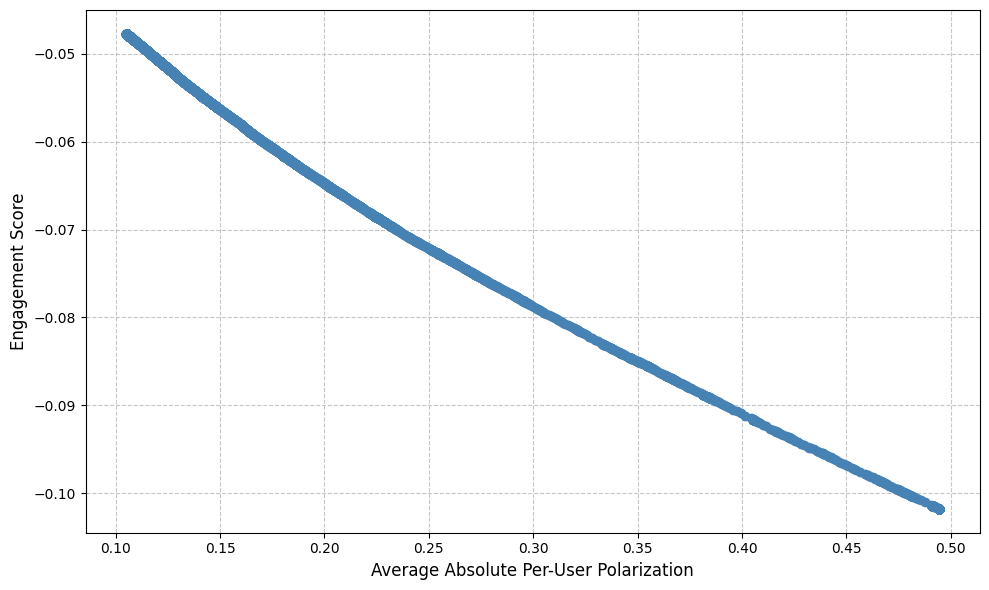

In [16]:
# Define colors and line width
engagement_color = 'steelblue'
polarization_color = 'darkred'
line_width = 2

# Trade-off plot: Engagement vs. Polarization
plt.figure(figsize=(10, 6))  # Standard figure size for consistency
plt.plot(
    polarization_history, 
    engagement_history, 
    marker='o', 
    linestyle='-', 
    color=engagement_color, 
    linewidth=line_width
)
plt.xlabel('Average Absolute Per-User Polarization', fontsize=12)
plt.ylabel('Engagement Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Subtle dashed grid
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig('Final images/linear_Trade_off.png', dpi=300, bbox_inches='tight')

plt.show()




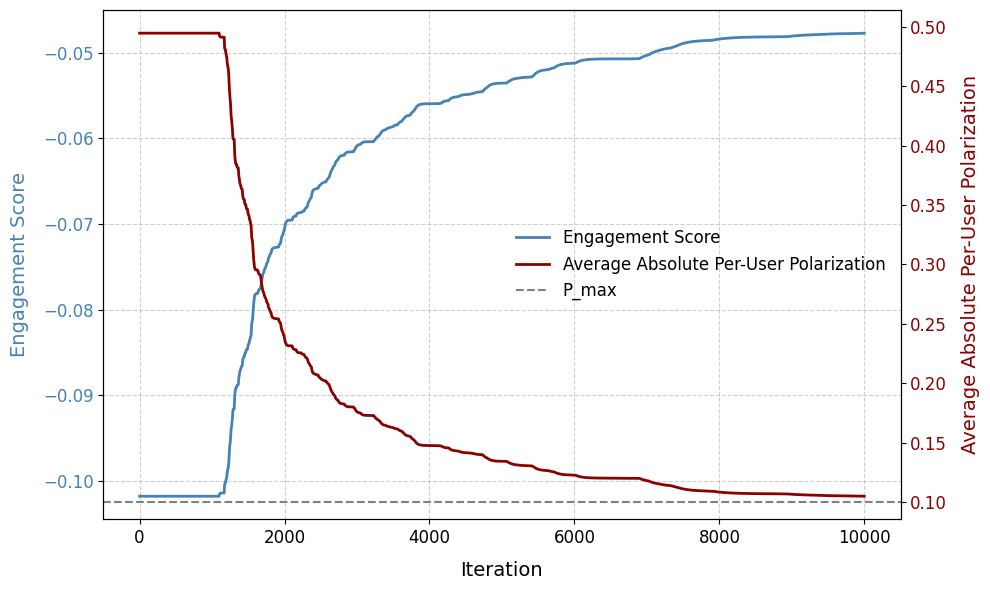

In [17]:
import matplotlib.pyplot as plt

# Define colors and line width
engagement_color = 'steelblue'
polarization_color = 'darkred'
line_width = 2

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Engagement Score
ax1.set_xlabel('Iteration', fontsize=14, labelpad=10)
ax1.set_ylabel('Engagement Score', fontsize=14, color=engagement_color, labelpad=10)
ax1.plot(iterations, engagement_history, color=engagement_color, lw=line_width, label='Engagement Score')
ax1.tick_params(axis='y', labelcolor=engagement_color)
ax1.tick_params(axis='both', labelsize=12)

# Second axis for Polarization
ax2 = ax1.twinx()
ax2.set_ylabel('Average Absolute Per-User Polarization', fontsize=14, color=polarization_color, labelpad=10)
ax2.plot(iterations, polarization_history, color=polarization_color, lw=line_width, label='Average Absolute Per-User Polarization')
ax2.axhline(y=P_max, color='gray', linestyle='--', linewidth=1.5, label='P_max')
ax2.tick_params(axis='y', labelcolor=polarization_color)
ax2.tick_params(axis='both', labelsize=12)

# Combine legends in the center-right of the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=12, frameon=False)

# Title and grid
# plt.title('Engagement Score and Average Absolute Per-User Polarization Over Iterations', fontsize=16, pad=15)
ax1.grid(visible=True, linestyle='--', alpha=0.6)

# Tight layout for better spacing
fig.tight_layout()

# Save the figure if needed
plt.savefig('Final images/engagement_polarization_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


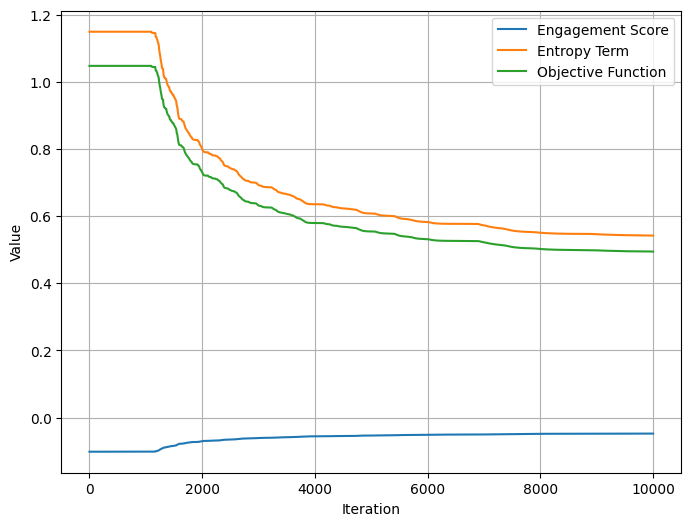

In [ ]:
# c. Objective Function Components Over Iterations
plt.figure(figsize=(8, 6))
plt.plot(iterations, engagement_history, label='Engagement Score')
entropy_history = [o - e for e, o in zip(engagement_history, objective_history)]
plt.plot(iterations, entropy_history, label='Entropy Term')
plt.plot(iterations, objective_history, label='Objective Function')
plt.xlabel('Iteration')
plt.ylabel('Value')
# plt.title('Objective Function Components Over Iterations')
plt.legend()
plt.grid(True)
plt.savefig('Final images/objective function.png', dpi=300, bbox_inches='tight')
plt.show()

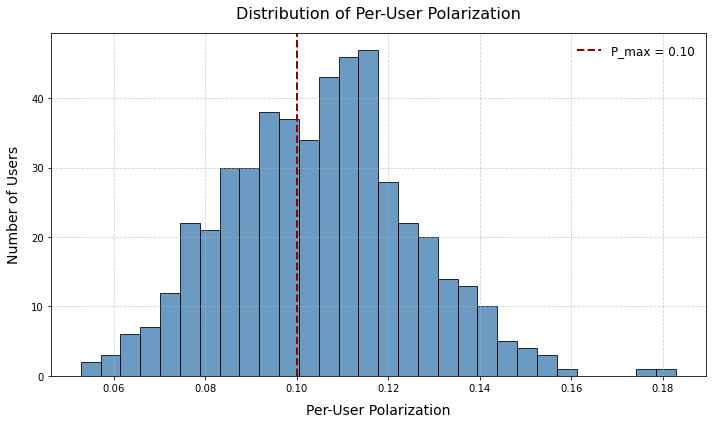

In [49]:

# Compute per-user polarization
Pi = results['Pi']
per_user_polarization = (Pi @ P) / a.flatten()

# Define formatting
hist_color = 'steelblue'
line_color = 'darkred'

# Plotting the distribution of per-user polarization
plt.figure(figsize=(10, 6))
plt.hist(per_user_polarization, bins=30, color=hist_color, edgecolor='black', alpha=0.8)
plt.axvline(x=P_max, color=line_color, linestyle='--', linewidth=2, label=f'P_max = {P_max:.2f}')

# Labels and Title
plt.xlabel('Per-User Polarization', fontsize=14, labelpad=10)
plt.ylabel('Number of Users', fontsize=14, labelpad=10)
plt.title('Distribution of Per-User Polarization', fontsize=16, pad=15)

# Add grid and legend
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure if needed
plt.savefig('Final images/per_user_polarization.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()